# Final Project: Detecting bots in wikipedia  streaming data

1) Consider all the changes done in the wikipedia as stream.
** Check here: https://wikitech.wikimedia.org/wiki/RCStream

2) Each action is received in json format. 

3) Data is full of bots. There is a flag were programmers can 
indicate that an actions has been done by a bot.

4) Using this information as ground truth, develop a system able 
to classify users as bot or human.

5) Constrain: You need to sample, and just use the 20% of 
the data stream. 

6) Describe the distribution of edits per users and bots. 

7) Finally, train a Bloom Filter that filter out bots from the stream. 

* Find the correct parameters for the bloom filter having an 
error below 10%.

8) If you want to have a 100% you need to do this:

* Make your system to work with Spark Streaming (5%)

In [1]:
from sseclient import SSEClient as EventSource
import time
import json

In [2]:
# Define helper functions

def get_bin(x, bin_width, start=0): 
    return (x - start) // bin_width

def fetch_raw(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        yield (change)


def hash_user(wiki, id):
    return hash((wiki, id))

def fetch_users(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        user = hash_user(change["wiki"], change["title"], change["user"])
        if user in observed_users:
            if print_log:
                print(f"Message from user {user} saved")
            save_user = True
        elif user in skipped_users:
            if print_log:
                print(f"Message from user {user} skipped")
            save_user = False
        else:
            # new user   
            if user_counter % event_decimation == 0:
                if print_log:
                    print(f"+ Add new user {user}")
                observed_users.add(user)
                save_user = True
            else:
                if print_log:
                    print(f"- Add Skip user {user}")
                skipped_users.add(user)
                save_user = False
            user_counter += 1

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        if save_user:
            yield (change)

In [3]:
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki"}#, "wikidatawiki"}
wikis_str = "_".join(wikis)

In [70]:
# fetching_time_sec = 800

# raw_items = [change for change in fetch_raw(EventSource(url), fetching_time_sec, message_types, wikis)]

In [92]:
# raw_items[0]

{'$schema': '/mediawiki/recentchange/1.0.0',
 'meta': {'uri': 'https://en.wikipedia.org/wiki/George_Santos',
  'request_id': '7853eaf3-e784-46d0-8030-5515bea95a3e',
  'id': '04b13719-4ad1-4018-b01e-419bd9fb1edb',
  'dt': '2023-11-21T19:51:25Z',
  'domain': 'en.wikipedia.org',
  'stream': 'mediawiki.recentchange',
  'topic': 'codfw.mediawiki.recentchange',
  'partition': 0,
  'offset': 785902126},
 'id': 1696879635,
 'type': 'edit',
 'namespace': 0,
 'title': 'George Santos',
 'title_url': 'https://en.wikipedia.org/wiki/George_Santos',
 'comment': 'added link',
 'timestamp': 1700596285,
 'user': 'TheHetStopper',
 'bot': False,
 'notify_url': 'https://en.wikipedia.org/w/index.php?diff=1186232574&oldid=1186214513',
 'minor': False,
 'length': {'old': 284532, 'new': 284675},
 'revision': {'old': 1186214513, 'new': 1186232574},
 'server_url': 'https://en.wikipedia.org',
 'server_name': 'en.wikipedia.org',
 'server_script_path': '/w',
 'wiki': 'enwiki',
 'parsedcomment': 'added link'}

# Analyze bot behaviour

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.DataFrame(raw_items)
samples = []
# with open('sample.jsonl', 'r') as fin:
#     samples.extend(list(map(json.loads, fin.readlines())))
with open('sample_unique_users.jsonl', 'r') as fin:
    samples.extend(list(map(json.loads, fin.readlines())))
# with open('sample_unique_users2.jsonl', 'r') as fin:
#     samples.extend(list(map(json.loads, fin.readlines())))
# with open('sample_unique_users3.jsonl', 'r') as fin:
#     samples.extend(list(map(json.loads, fin.readlines())))

df = pd.DataFrame(samples)


df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

len(df)

13397

## Bot vs Real user edit length

In [12]:
df[df['bot']].sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff,revision_diff,length_bucket,revision_bucket
10949,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/User_ta...,1697280638,edit,3,User talk:Jauerback,https://en.wikipedia.org/wiki/User_talk:Jauerback,Archiving 2 discussion(s) to [[User talk:Jauer...,1700715423,Lowercase sigmabot III,...,en.wikipedia.org,/w,enwiki,"Archiving 2 discussion(s) to <a href=""/wiki/Us...",7972,5825,-2147,105110,7201,10510


In [13]:
df[~df['bot']].sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff,revision_diff,length_bucket,revision_bucket
3661,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/List_of...,1697199399,edit,0,List of United States tornadoes from September...,https://en.wikipedia.org/wiki/List_of_United_S...,/* November 20 event */ +2,1700691499,United States Man,...,en.wikipedia.org,/w,enwiki,"<span dir=""auto""><span class=""autocomment""><a ...",49758,50646,888,891,7262,89


(0.0, 0.0025)

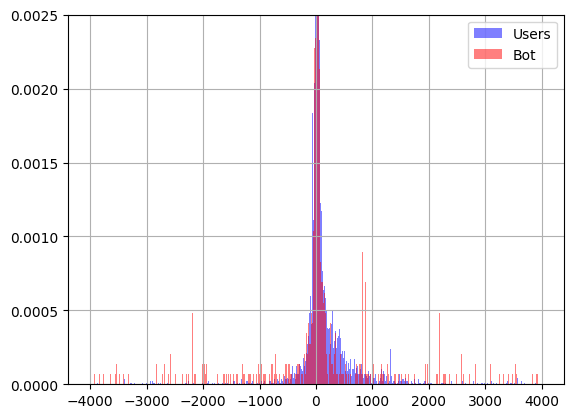

In [27]:
ax1 = plt.subplot(111)
df[~df['bot'] & (df['length_diff'].abs() < 4000)]['length_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=1000, density=True)
df[df['bot'] & (df['length_diff'].abs() < 4000)]['length_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5, bins=1000, density=True)
ax1.legend(loc='best')

ax1.set_ylim((0, 0.0025))
# ax1.set_xlim((-4000, 4000))

(0.0, 100.0)

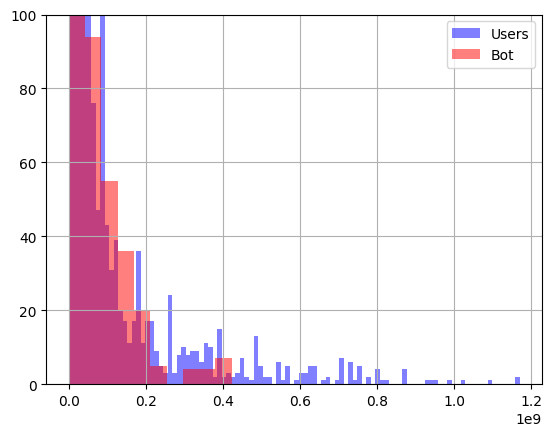

In [23]:
ax1 = plt.subplot(111)
df[~df['bot']]['revision_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=100)
df[df['bot']]['revision_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 100))

(0.0, 100000.0)

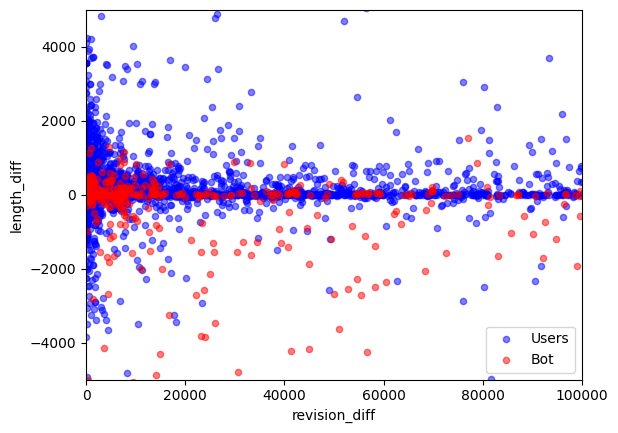

In [24]:
ax1 = plt.subplot(111)
df[~df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='blue', label='Users', alpha=0.5)
df[df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((-5000, 5000))
ax1.set_xlim((0, 100000))

Observations:
- real users makes bigger changes (>1k symbols per edit)
- changes between +/- 1k edited changes make both users and bots, so events are not distinguishable. Users do bigger and mostly additional edits (distribution right-skewed with longer tails comparing to bot distribution)
- bots has bot in the name (too obvious)
- bots generates comments in structured form
- revision diff is smaller for bots, it seems the reason is because bot need less time to make a change

## Bot behaviour

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


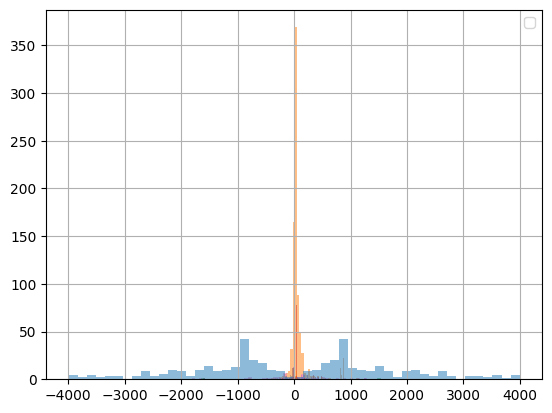

In [34]:
ax1 = plt.subplot(111)
df[df['bot'] & (df['length_diff'].abs() < 4000)].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5, bins=50)
ax1.legend(loc='best')

# ax1.set_ylim((0, 12))

In [35]:
# df[df['bot']].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5)

_df = df[df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index                    user length_diff                            \
                                       count         mean          std   
0      0                   B-bot           2   -51.000000     0.000000   
1      1            Citation bot         798    36.763158    97.181473   
2      2      Community Tech bot           4 -1929.250000  3998.451148   
3      3                  DatBot         135    84.244444   132.411980   
4      4            DeltaQuadBot         139    19.244604   125.929750   
5      5                 DumbBOT          17  2267.294118  9801.714166   
6      6               EarwigBot          44   -27.363636   610.178895   
7      7         Filedelinkerbot          39   -60.589744    96.041854   
8      8                KiranBOT          35     1.742857    10.310882   
9      9               LivingBot           4     6.750000     7.410578   
10    10  Lowercase sigmabot III         585  -333.070085  9662.428095   
11    11              MilHistBot          38    42.894737    28.426091   
12    12             MusikBot II          37    -8.891892    18.721324   
13    13             Reports bot          34    14.529412    59.634866   
14    14                 RichBot           3   487.333333   685.621130   
15    15          SheepLinterBot          11    -0.636364     5.427204   
16    16      VRTS Migration Bot           2     1.000000     0.000000   
17    17               Yapperbot          45   745.533333   287.038531   

   mahalanobis  
                
0         -inf  
1     0.378294  
2    -0.482499  
3     0.636230  
4     0.152820  
5     0.231316  
6    -0.044845  
7    -0.630868  
8     0.169031  
9     0.910860  
10   -0.034471  
11    1.508992  
12   -0.474961  
13    0.243640  
14    0.710791  
15   -0.117254  
16         inf  
17    2.597328

In [37]:
_df = df[~df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index            user length_diff                         mahalanobis
                                 count        mean         std            
0        0        01101010           4   18.500000   12.662280    1.461032
3        3  100.16.220.216           2    2.000000    1.414214    1.414214
4        4  100.38.103.195           2   20.500000    3.535534    5.798276
6        6  101.183.49.215           2  322.500000   30.405592   10.606602
9        9  103.119.140.70           3  138.333333  118.158086    1.170748
...    ...             ...         ...         ...         ...         ...
2280  2280           Zsinj           3   60.333333   82.233408    0.733684
2283  2283            Zyxw          84   85.023810  106.038295    0.801822
2286  2286   খাত্তাব হাসান           4  127.250000  233.972042    0.543868
2288  2288             庄育航           3   -4.000000    8.000000   -0.500000
2289  2289           清风与明月           8   -9.250000   11.055057   -0.836721

[1171 rows x 6 columns]

In [38]:
df[df['bot']]['user'].unique()

array(['DatBot', 'KiranBOT', 'DeltaQuadBot', 'Citation bot', 'EarwigBot',
       'Filedelinkerbot', 'Reports bot', 'MusikBot II', 'B-bot',
       'VRTS Migration Bot', 'Community Tech bot', 'RichBot',
       'Lowercase sigmabot III', 'Yapperbot', 'MilHistBot', 'LivingBot',
       'DumbBOT', 'SheepLinterBot'], dtype=object)

In [39]:
df[df['bot']]['comment'].sample(20).unique()

array(['[[WP:FRS|Feedback Request Service]] notification on a "Wikipedia style and naming" request for comment (1/2 this month). You can unsubscribe at [[WP:FRS]].',
       '[[WP:Bots|Bot]] · [[User:EarwigBot#Task 2|Task 2]] · Updating statistics for [[WP:WPAFC|WikiProject Articles for creation]].',
       'Updating new discussions: [[Talk:Alicia Moreau de Justo]]',
       'Archiving 1 discussion(s) from [[Talk:Jordan Peterson]]) (bot',
       'Archiving 2 discussion(s) to [[Wikipedia talk:WikiProject Women in Red/Archive 134]]) (bot',
       'Archiving 2 discussion(s) from [[Talk:Unitarianism]]) (bot',
       'updated log - location',
       'Reverted edit by [[Special:Contribs/Filedelinkerbot|Filedelinkerbot]] ([[User talk:Filedelinkerbot|talk]]) to last version by 124.104.31.88',
       'Archiving 2 discussion(s) to [[User talk:ClaudineChionh/Archive 2023]]) (bot',
       'Alter: pages. Formatted [[WP:ENDASH|dashes]]. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Sug

Observations:

- The bot title and comment seems to be significant features because uses special characters and more-less structured.
- Bots has different distributions: some do inserts and deletes that leads to two-modes bumps, some does small changes in page

# Collect data for model training

In [40]:
# fetching_time_sec = 30000
# url = 'https://stream.wikimedia.org/v2/stream/recentchange'
# message_types = {"edit"}
# wikis = {"enwiki"}#, "wikidatawiki"}
# wikis_str = "_".join(wikis)

# with open('sample1.jsonl', 'w') as fout:
#     for item in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis):
#         fout.write(json.dumps(item) + "\n")


# Read data

In [41]:
with open('sample_unique_users.jsonl', 'r') as fin:
    samples = list(map(json.loads, fin.readlines()))

df = pd.DataFrame(samples)

df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

df.drop_duplicates(['user', 'title', 'comment'], inplace=True)

len(df)

11571

In [42]:
df[['user', 'bot' ,'comment']].value_counts().reset_index().sort_values('count', ascending=True)

,user,bot,comment,count
4231,RoyMM,False,Uploaded the newly released IMAX release image,1
5650,24.108.18.81,False,Nova Scotia reference; + QC update from https:...,1
5649,24.108.18.81,False,Nova Scotia update from https://novascotia.ca/...,1
5648,24.113.170.82,False,[[WP:AES|←]]Changed redirect target from [[49e...,1
5647,24.115.150.125,False,,1
...,...,...,...,...
4,Caber33,False,,90
3,Simeon,False,add banner shell,101
2,Johnpacklambert,False,,106
1,DeltaQuadBot,False,(Image Revdel) Orphaned non-free file(s) delet...,136


In [43]:
import math 
import hashlib
import mmh3 
from bitarray import bitarray 
  
  
class BloomFilterBaseline(object): 
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        self._size = BloomFilter.calculate_size(self._filter_capacity, self._fp_error_rate)
        self._hash_functions = [
            lambda x: int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big'), 
            # mmh3.hash
        ]
        self._mask_array = [0] * self._size

    @staticmethod
    def calculate_size(items_number, fp_error_rate):
        ''' 
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2) 
        '''        
        return int(-(items_number * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            for hash_func in self._hash_functions:
                index = hash_func(x) % self._size
                self._mask_array[index] = 1

    def predict_one(self, item):
        for hash_func in self._hash_functions:
            index = hash_func(item) % self._size
            if not self._mask_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]



class BloomFilter(object): 
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        # number of buckets
        self._num_buckets = BloomFilter.calculate_num_buckets(self._filter_capacity, self._fp_error_rate)
        # number of hash functions to use for registering single record (functions differs by seed)
        self._num_hash_funcs = BloomFilter.calculate_num_of_hash_func(self._filter_capacity, self._num_buckets)
        
        self._buckets_array = [0] * self._num_buckets

    @staticmethod
    def calculate_num_buckets(items_number, fp_error_rate):
        ''' 
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2) 
        '''        
        return int(-(items_number * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    @staticmethod
    def calculate_num_of_hash_func(items_number, num_bits):
        return max(1, round(num_bits / items_number * math.log(2)))

    def _calc_hash(self, x, seed):
        return mmh3.hash(x, seed) % self._num_buckets

    def _add(self, x):
        for seed in range(self._num_hash_funcs):
            index = self._calc_hash(x, seed)
            self._buckets_array[index] = 1
   
    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            self._add(x)
            
    def predict_one(self, x):
        for seed in range(self._num_hash_funcs):
            index = self._calc_hash(x, seed)
            if not self._buckets_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]


In [44]:
def extract_features(item):
    return item['user']

def extract_label(item):
    return item['bot']

In [53]:
import random
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

random.seed(42)

def get_train_test_random(_df, _extract_features=extract_features, _extract_label=extract_label):
    X = list(map(_extract_features, df.to_dict('records')))
    Y = list(map(_extract_label, df.to_dict('records')))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

def get_train_test_users(_df, _extract_features=extract_features, _extract_label=extract_label):
    names = df.user.unique()
    names_train = random.choices(names, k=int(len(names)*0.8))
    df_train = df[df.user.isin(names_train)]
    df_test = df[~df.user.isin(names_train)]
    
    X_train = list(map(extract_features, df_train.to_dict('records')))
    Y_train = list(map(extract_label, df_train.to_dict('records')))
    
    X_test = list(map(extract_features, df_test.to_dict('records')))
    Y_test = list(map(extract_label, df_test.to_dict('records')))
    return X_train, X_test, Y_train, Y_test

In [46]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df)

### Sanity check

In [47]:
model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

In [48]:
y_pred = model.predict(X_test)

In [49]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1974
        True       0.88      1.00      0.94       341

    accuracy                           0.98      2315
   macro avg       0.94      0.99      0.96      2315
weighted avg       0.98      0.98      0.98      2315



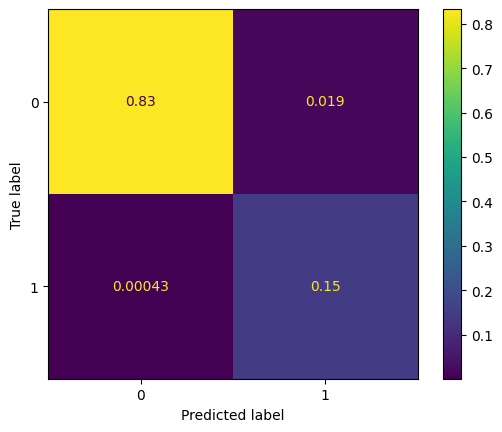

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred) / len(Y_test))
disp.plot()

In [58]:
f1_score(Y_test, y_pred)

0.9366391184573004

It looks classifier works as bot detection by names (it remembers user name of bots).

# Configuration search

## Features

- user name
- comment
- edit size
- revision diff
- edit + revision diff

### user name

use split by users

In [59]:
def extract_features(item):
    return item['user']

X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = np.array(model.predict(X_test))

f1_score(Y_test, y_pred)

0.0

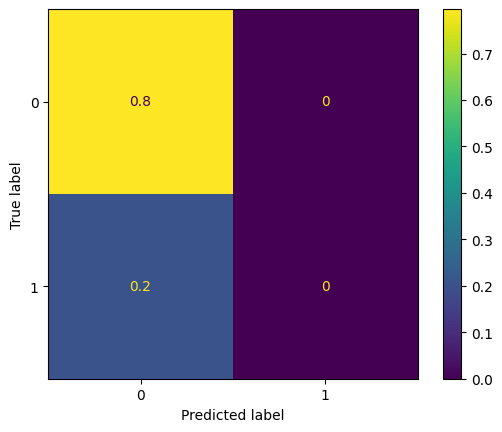

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred) / len(Y_test))
disp.plot()

False positive rate is ~0.1% that is close to teoretical.

### comment 

In [61]:
def extract_features(item):
    return item['comment']

#### Split randomly

In [62]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.22670025188916876

#### Split by user

In [63]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.007772020725388601

It seems bot users uses the same comments, but different bots uses different comments. This feature is not robust and needs additional investigation and preprocessing like BoW.

### edit length

In [64]:
def extract_features(item):
    return str(item['length_diff'])

#### Split randomly

In [65]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.23574561403508776

#### Split by user

In [66]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.23694193171870442

### edit length bucket

In [67]:
def extract_features(item):
    return str(item['length_bucket'])

#### Split randomly

In [68]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.23932281646787226

#### Split by user

In [69]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.08958377350517642

### revision diff

In [70]:
def extract_features(item):
    return str(item['revision_diff'])

#### Split randomly

In [71]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.13488372093023257

#### Split by user

In [72]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.05755395683453238

### revision diff bucket

In [73]:
def extract_features(item):
    return str(item['revision_bucket'])

#### Split randomly

In [74]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.13165266106442577

#### Split by user

In [75]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.023405500292568753

### Conclusions

- we observe significant gap between f1-scores depending on dataset split strategy: random split and per user split.
- Such a small scores for per user split strategy (considering Bloom filter specifics) were cased by small sample (only 3205 users contains in dataset, 51 users are bots). To increase scores we should increase test size
- there are few potential interesting features: comments and revision diff bucket that could be used for bot training.
- numbers bucketing improves performance of the model comparing to using actual numeric values. This idea matches with Bloom filter intuition but mask is generated depending on the value and is comparable (close values has higher chance to have the same hash sum)

## Parameters finetuning

There are few Bloom filter's parameters to finetune:
- filter capacity
- FP rate

Let's use comment as primary feature and find the best parameters to maximize f1 score for per-user split

In [76]:
def extract_features(item):
    return item['comment']

def extract_label(item):
    return item['bot']


X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

results = []

for item_count in [1, np.sum(Y_train)//50, np.sum(Y_train)//20, np.sum(Y_train)//10, np.sum(Y_train)/2, np.sum(Y_train)]:
    for fp_rate in [0.01, 0.05, 0.1, 0.2, 0.3]:

        model = BloomFilter(item_count, fp_rate)
        model.fit(X_train, Y_train)

        y_pred = model.predict(X_test)
        results.append({
            'fp_rate': fp_rate,
            'item_count': item_count,
            'f1_score': f1_score(Y_test, y_pred)
        })
pd.DataFrame(results).sort_values('f1_score', ascending=False)

,fp_rate,item_count,f1_score
16,0.05,101.0,0.225215
18,0.20,101.0,0.224443
24,0.30,505.0,0.224289
10,0.01,50.0,0.224024
17,0.10,101.0,0.224024
1,0.05,1.0,0.224024
14,0.30,50.0,0.224024
13,0.20,50.0,0.224024
12,0.10,50.0,0.224024
11,0.05,50.0,0.224024


The best score we can get for item numbers 53 and fp_rate = 5%

In [77]:
model = BloomFilter(101, 0.05)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.03      0.05      5071
        True       0.13      0.98      0.23       732

    accuracy                           0.15      5803
   macro avg       0.52      0.50      0.14      5803
weighted avg       0.81      0.15      0.07      5803

